In [1]:
from ultralytics import YOLO
from ultralytics.utils.metrics import mask_iou
from torch import Tensor
import cv2
import numpy as np
import pandas as pd

In [2]:
model = YOLO('./runs/segment/train2/weights/best.pt')
img_size = 1024

In [3]:
def read_and_normalize_mask(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)

    _, mask = cv2.threshold(image, 0.5, 1, cv2.THRESH_BINARY)

    mask = mask.reshape(-1, int(image.shape[1] * image.shape[0]))

    return Tensor(mask)

def get_iou(yolo_model, img_path):
    results = yolo_model(img_path)
    true_mask = read_and_normalize_mask(img_path.replace("images", "masks"))
    
    assert len(results) == 1, "support only len == 1"
    for r in results:
        if isinstance(r.masks, type(None)): return None
        masks = r.masks.data.reshape(-1, img_size*img_size).cpu()
        masks = np.any(np.array(masks), axis=0)
        masks = masks.reshape(-1, img_size*img_size)
        print(masks)
        masks = Tensor(masks)
    
        return mask_iou(true_mask, masks)


In [4]:
# get an average iou
import os
import numpy as np

image_directory = "/dev/bakalarka-yolo/data/ch-test(SOHO)/images/"

iou_values = []
for image_path in os.listdir(image_directory):
    if image_path.endswith(".png"):
        result = get_iou(model, os.path.join(image_directory, image_path))
        if result != None:
            iou = result.tolist()[0][0]
            iou_values.append(iou)

average_iou = np.mean(iou_values)
median = np.median(iou_values)


image 1/1 /dev/bakalarka-yolo/data/ch-test(SOHO)/images/20171114_1313_eit195_1024.png: 1024x1024 3 coronal holes, 72.8ms
Speed: 3.6ms preprocess, 72.8ms inference, 2.8ms postprocess per image at shape (1, 3, 1024, 1024)
[[False False False ... False False False]]

image 1/1 /dev/bakalarka-yolo/data/ch-test(SOHO)/images/20110105_0113_eit195_1024.png: 1024x1024 5 coronal holes, 72.8ms
Speed: 2.0ms preprocess, 72.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)
[[False False False ... False False False]]

image 1/1 /dev/bakalarka-yolo/data/ch-test(SOHO)/images/20161026_1313_eit195_1024.png: 1024x1024 4 coronal holes, 72.8ms
Speed: 2.0ms preprocess, 72.8ms inference, 1.5ms postprocess per image at shape (1, 3, 1024, 1024)
[[False False False ... False False False]]

image 1/1 /dev/bakalarka-yolo/data/ch-test(SOHO)/images/20130427_0113_eit195_1024.png: 1024x1024 3 coronal holes, 69.6ms
Speed: 2.1ms preprocess, 69.6ms inference, 1.5ms postprocess per image at shape (1,

In [5]:
%%capture cell
val_res = model.val(data='./ch-SOHO.yaml', imgsz=1024, split="test")

Ultralytics YOLOv8.1.23 🚀 Python-3.10.10 torch-2.2.1+cu121 CUDA:0 (NVIDIA TITAN RTX, 24210MiB)
val: New cache created: /dev/bakalarka-yolo/data/ch-test(SOHO)/images-col.cache
                   all       1977       2930      0.705      0.498       0.58      0.341      0.732      0.466      0.546      0.253
Speed: 0.5ms preprocess, 59.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/segment/val2


In [6]:
dice = val_res.seg.f1
print("Dice score:", dice[0])
print("IoU:", average_iou)

# results for ch 
# Dice score: 0.5563138232924477
# IoU: 0.6986303846845785

# results for ar grayscale
# Dice score: 0.2924788789771119
# IoU: 0.32751943564349206

# results for ch soho
# Dice score: 0.569427672482262
# IoU: 0.6698140347881835

# results for ar soho
# Dice score: 0.44100682104197647
# IoU: 0.46968485340150384

Dice score: 0.569427672482262
IoU: 0.6698140347881835


In [24]:
!cp /dev/bakalarka-yolo/data/ar-test\(SOHO\) data/ar-test\(SOHO\) -r

In [5]:
import sys 
sys.path.append('./scss-net/src')


image 1/1 /home/jovyan/work/bakalarka-yolov8/data/ch-test(region_growth)/images/2017_01_03__22_59_52_84__SDO_AIA_AIA_193.png: 256x256 1 coronal hole, 21.5ms
Speed: 0.5ms preprocess, 21.5ms inference, 2.9ms postprocess per image at shape (1, 3, 256, 256)
1/1 [==============================] - 0s 498ms/step


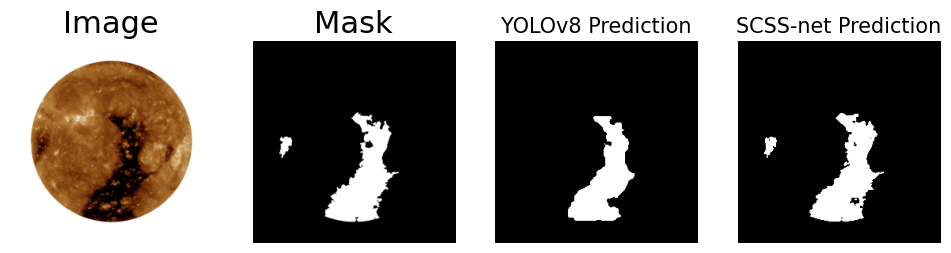

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from ultralytics import YOLO
import zipfile
import glob
from datetime import datetime
from PIL import Image
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from model_scss_net import scss_net
from metrics import dice_np, iou_np, dice, iou
from utils import plot_imgs, plot_metrics


def show_prediction(img_path, mode="ar"): 
    if mode == "ar":
        yolo_model = YOLO('ar-grayscale.pt')
    if mode == "ch":
        yolo_model = YOLO('ch-region.pt')
    
    result = yolo_model.predict(img_path, save=False, imgsz=256, show_boxes=False)

    mask_tensors = result[0].masks.data

    dimention = result[0].masks.shape[1]
    prediction = np.full((dimention, dimention, 3), 0, dtype=np.uint8)

    for mask_tensor in mask_tensors:
        mask_array = mask_tensor.cpu().numpy().astype(np.uint8)
        prediction[mask_array == 1] = 255
    fig, axes = plt.subplots(1, 4, figsize=(12, 4), squeeze=False)
    
    #     code of scss-net
    model = scss_net(
    (256, 256, 1),
    filters=32,  
    layers=4,
    batch_norm=True,
    drop_prob=0.5)
    
    model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  
    metrics=[iou, dice])
    
    if mode == "ar":
        model.load_weights("model_ar_spoca.h5")
    if mode == "ch":
        model.load_weights("model_ch_region.h5")

    imgs_test = [img_path]
    masks_test = [img_path.replace("images", "masks")]

    # Load data and convert imgs to np.array
    imgs_list = []
    masks_list = []
    for image, mask in zip(imgs_test, masks_test):
        imgs_list.append(np.array(Image.open(image).convert("L")))
        masks_list.append(np.array(Image.open(mask).convert("L")))

    # Normalization from (0; 255) to (0; 1)
    x_test = np.asarray(imgs_list, dtype=np.float32)/255
    y_test = np.asarray(masks_list, dtype=np.float32)/255

    # Reshape to (n_imgs, height, width, channels)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
    y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 1)
    
    y_pred = model.predict(x_test)
    y_pred_bin = np.where(y_pred > 0.5, 1, 0)
    axes[0, 3].imshow(y_pred_bin[0], cmap="gray", interpolation=None)
    #     code of scss-net
    
    axes[0, 0].set_axis_off()
    axes[0, 1].set_axis_off()
    axes[0, 2].set_axis_off()
    axes[0, 3].set_axis_off()
    axes[0, 0].set_title("Image", fontsize=22)
    axes[0, 1].set_title("Mask", fontsize=22)
    axes[0, 2].set_title("YOLOv8 Prediction", fontsize=15)
    axes[0, 3].set_title("SCSS-net Prediction", fontsize=15)
    img = np.array(Image.open(img_path.replace("images", "images-col")))
    mask = np.array(Image.open(img_path.replace("images", "masks")))
    axes[0, 0].imshow(img, cmap="gray")
    axes[0, 1].imshow(mask)
    axes[0, 2].imshow(prediction)
    plt.show()

show_prediction('./data/ch-test(region_growth)/images/2017_01_03__22_59_52_84__SDO_AIA_AIA_193.png', mode="ch")


image 1/1 /home/jovyan/work/bakalarka-yolov8/data/ar-test(SOHO)/images/20110106_0100_eit171_1024.png: 256x256 1 active region, 20.0ms
Speed: 1.3ms preprocess, 20.0ms inference, 3.0ms postprocess per image at shape (1, 3, 256, 256)
1/1 [==============================] - 0s 499ms/step


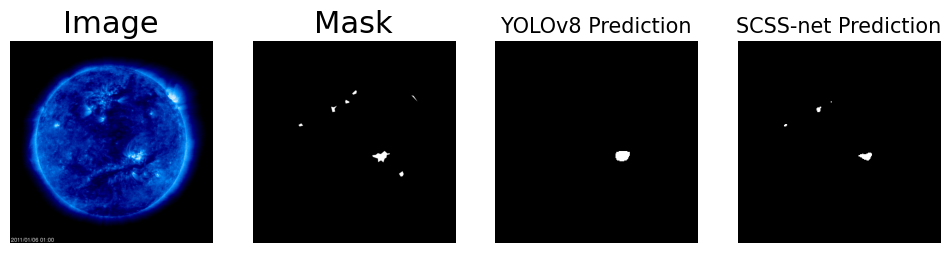

In [13]:
IMG_SIZE=256
def show_prediction_soho(img_path, mode="ar"): 
    yolo_model = YOLO(f'my-soho-{mode}.pt')
    
    result = yolo_model.predict(img_path, save=False, imgsz=256, show_boxes=False)

    mask_tensors = result[0].masks.data

    dimention = result[0].masks.shape[1]
    prediction = np.full((dimention, dimention, 3), 0, dtype=np.uint8)

    for mask_tensor in mask_tensors:
        mask_array = mask_tensor.cpu().numpy().astype(np.uint8)
        prediction[mask_array == 1] = 255
    fig, axes = plt.subplots(1, 4, figsize=(12, 4), squeeze=False)
    
    #     code of scss-net
    model = scss_net(
    (256, 256, 1),
    filters=32,  
    layers=4,
    batch_norm=True,
    drop_prob=0.5)
    
    model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  
    metrics=[iou, dice])
    
    if mode == "ar":
        model.load_weights("soho_ar_model.h5")
    if mode == "ch":
        model.load_weights("soho_ch_model.h5")

    imgs_test = [img_path]
    masks_test = [img_path.replace("images", "masks")]

    # Load data and convert imgs to np.array
    imgs_list = []
    masks_list = []
    for image, mask in zip(imgs_test, masks_test):
        imgs_list.append(np.array(Image.open(image).convert("L").resize((IMG_SIZE, IMG_SIZE))))
        masks_list.append(np.array(Image.open(mask).convert("L").resize((IMG_SIZE, IMG_SIZE))))

    # Normalization from (0; 255) to (0; 1)
    x_test = np.asarray(imgs_list, dtype=np.float32)/255
    y_test = np.asarray(masks_list, dtype=np.float32)/255

    # Reshape to (n_imgs, height, width, channels)
    x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
    y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 1)
    
    y_pred = model.predict(x_test)
    y_pred_bin = np.where(y_pred > 0.5, 1, 0)
    axes[0, 3].imshow(y_pred_bin[0], cmap="gray", interpolation=None)
    #     code of scss-net
    
    axes[0, 0].set_axis_off()
    axes[0, 1].set_axis_off()
    axes[0, 2].set_axis_off()
    axes[0, 3].set_axis_off()
    axes[0, 0].set_title("Image", fontsize=22)
    axes[0, 1].set_title("Mask", fontsize=22)
    axes[0, 2].set_title("YOLOv8 Prediction", fontsize=15)
    axes[0, 3].set_title("SCSS-net Prediction", fontsize=15)
    img = np.array(Image.open(img_path.replace("images", "images-col")))
    mask = np.array(Image.open(img_path.replace("images", "masks")))
    axes[0, 0].imshow(img, cmap="gray")
    axes[0, 1].imshow(mask)
    axes[0, 2].imshow(prediction)
    plt.show()

show_prediction_soho('./data/ar-test(SOHO)/images/20110106_0100_eit171_1024.png', mode="ar")